In [11]:
import pandas as pd
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from matplotlib.style import use
use('fivethirtyeight')

In [5]:
df = pd.read_csv('./data/winemag-data_first150k.csv')

In [6]:
df.head(10)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude
5,5,Spain,"Deep, dense and pure from the opening bell, th...",Numanthia,95,73.0,Northern Spain,Toro,NaN,Tinta de Toro,Numanthia
6,6,Spain,Slightly gritty black-fruit aromas include a s...,San Román,95,65.0,Northern Spain,Toro,NaN,Tinta de Toro,Maurodos
7,7,Spain,Lush cedary black-fruit aromas are luxe and of...,Carodorum Único Crianza,95,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
8,8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
9,9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm


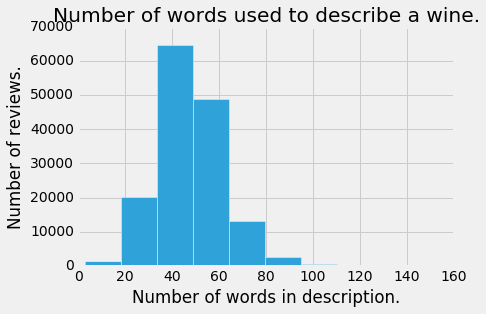

In [13]:
# df['description'].apply(func=lambda text: len(word_tokenize(text))).hist()
# # plt.title('Number of words used to describe a wine.')
# # plt.xlabel('Number of words in description.')
# # plt.ylabel('Number of reviews.')
# plt.show()

In [14]:
df.columns

Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'variety', 'winery'],
      dtype='object')

### Data Features
- *Points*: the number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80)
- *Variety*: the type of grapes used to make the wine (ie Pinot Noir)
- *Description*: a few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.
- *Country*: the country that the wine is from
- *Province*: the province or state that the wine is from
- *Region 1*: the wine growing area in a province or state (ie Napa)
- *Region 2*: sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank
- *Winery*: the winery that made the wine
- *Designation*: the vineyard within the winery where the grapes that made the wine are from
- *Price*: the cost for a bottle of the wine

### Explore feature distribution
We are looking for good labels, i.e. indicators of quality of the wine. We'll explore *Points* and *Price* feature.

False


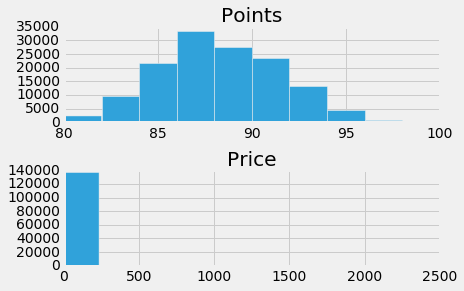

In [80]:
df = df.dropna(subset=['price', 'points'])

f, axxar = plt.subplots(2, 1)
axxar[0].hist(df['points'])
axxar[0].set_title('Points')
axxar[1].hist(df['price'])
axxar[1].set_title('Price')
f.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

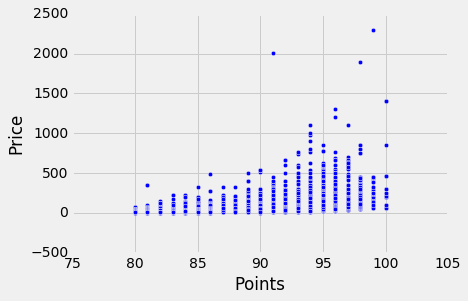

In [36]:
plt.scatter(df['points'], df['price'])
plt.xlabel('Points')
plt.ylabel('Price')
plt.show()

We can see that prize does not add much information. We'll use only *points* as the feature.

## Classification
We'll try to classify the best wines and the worst wines in the dataset. We use 25% of wines with lowest number of points as *bad* wines and 25% of wines with the highest number of points as the *good* wines.

In [112]:
df = df.dropna(subset=['description'])

df_sorted = df.sort_values(by='points', ascending=True)

num_of_wines = df_sorted.shape[0]
worst = df_sorted.head(int(0.25*num_of_wines))
best = df_sorted.tail(int(0.25*num_of_wines))

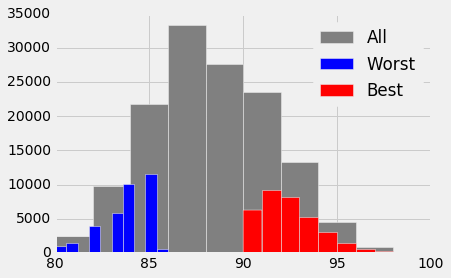

In [113]:
plt.hist(df['points'], color='grey', label='All')
plt.hist(worst['points'], color='blue', label='Worst')
plt.hist(best['points'], color='red', label='Best')
plt.legend()
plt.show()

In [114]:
from nltk.tokenize import word_tokenize
from nltk import FreqDist, NaiveBayesClassifier
from random import shuffle

In [116]:
worst['words'] = worst['description'].apply(func=lambda text: word_tokenize(text.lower()))
best['words'] = best['description'].apply(func=lambda text: word_tokenize(text.lower()))
worst = worst.dropna(subset=['words'])
best = best.dropna(subset=['words'])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [117]:
all_words = []
for description in worst['words'].values:
    for word in description:
        all_words.append(word)
for description in best['words'].values:
    for word in description:
        all_words.append(word)
all_words = FreqDist(all_words)
words_features = list(all_words.keys())[:3000]

In [118]:
def find_features(doc):
    words = set(doc)
    features = {}
    for w in words_features:
        features[w] = bool(w in words)
    return features
featureset = ([(find_features(description), 'worst') for description in worst['words']] +
              [(find_features(description), 'best') for description in best['words']])

In [100]:
shuffle(featureset)

In [121]:
classifier = NaiveBayesClassifier.train(labeled_featuresets=featureset)

In [123]:
classifier.show_most_informative_features(50)

Most Informative Features
                now–2015 = True             best : worst  =    189.7 : 1.0
                   weedy = True            worst : best   =    119.0 : 1.0
              gracefully = True             best : worst  =    117.7 : 1.0
                    2018 = True             best : worst  =     86.5 : 1.0
                 amazing = True             best : worst  =     77.8 : 1.0
             exceptional = True             best : worst  =     55.2 : 1.0
                superbly = True             best : worst  =     54.3 : 1.0
                stunning = True             best : worst  =     48.3 : 1.0
              unbalanced = True            worst : best   =     41.5 : 1.0
                 generic = True            worst : best   =     40.5 : 1.0
                 burgers = True            worst : best   =     30.5 : 1.0
                   pasty = True            worst : best   =     30.3 : 1.0
                 massive = True             best : worst  =     27.0 : 1.0